In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import welly
import os
env = %env
from welly import Well
import lasio

In [10]:
# Install a conda package in the current Jupyter kernel
import sys
# !conda install --yes --prefix {sys.prefix} welly

{'D:\\anaconda3'}

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install welly

In [8]:
import os
os.getcwd()

'D:\\Users\\drome\\gitrepos\\spe 06\\MannvilleGroup_Strat_Hackathon'

In [2]:
import pandas as pd
ds = pd.read_csv('./SPE_006_originalData/OilSandsDB/PICKS_DIC.TXT',delimiter='\t')
picks = pd.read_csv('./SPE_006_originalData/OilSandsDB/PICKS.TXT',delimiter='\t')
wells = pd.read_csv('./SPE_006_originalData/OilSandsDB/WELLS.TXT',delimiter='\t')
picks_new=picks[picks['HorID']==13000]
df_new=pd.merge(wells, picks_new, on='SitID')
df_new.head()

SitID      UWI (AGS)                  UWI  HorID Pick  Quality
0  102496  0674010812000  00/12-08-067-01W4/0  13000  475        3
1  102497  0674020807000  00/07-08-067-02W4/0  13000  515        3
2  102498  0674021109000  00/09-11-067-02W4/0  13000  480        3
3  102500  0674022910000  00/10-29-067-02W4/0  13000  549        3
4  102501  0674023406000  00/06-34-067-02W4/0  13000  529        2

In [3]:
import glob
count=0
data_df=pd.DataFrame()
for file in glob.glob('./SPE_006_originalData/OilSandsDB/Logs/*.LAS'):
    if count >2:
        break
    count+=1  
    l_df = lasio.read(file).df()
   
    str_uwi= file[-23:-4].replace("-", "/",1)[:17]+file[-6:-4].replace("-", "/",1)
#    print (str_uwi)
    l_df = l_df.reset_index()
    l_df['UWI'] = str_uwi
    l_df['SitID']=df_new[df_new['UWI']==str_uwi]['SitID'].iloc[0]
    l_df['UWI (AGS)']=df_new[df_new['UWI']==str_uwi]['UWI (AGS)'].iloc[0]
    l_df['Pick']=df_new[df_new['UWI']==str_uwi]['Pick'].iloc[0] 
    l_df['HorID']=df_new[df_new['UWI']==str_uwi]['HorID'].iloc[0]
    l_df['Quality']=df_new[df_new['UWI']==str_uwi]['Quality'].iloc[0]

    print(l_df.Pick.unique()[0])  
    try:
        float(l_df.Pick.unique()[0])
        l_df.Pick = l_df.Pick.astype(float)
        l_df.DEPT = l_df.DEPT.astype(float)
        l_df['new_pick']=l_df['Pick']-l_df['DEPT']
        l_df['new_pick2']=l_df['new_pick'].apply(lambda x: 1 if(x==0) else 0)
        if count == 1:
            data_df=l_df
        if count >= 2:
            data_df=pd.concat([data_df, l_df])      
    except:
        print ('Error picking')
        continue;
        
      

607
        
Error picking
243


In [4]:
data_df.shape

(1559, 14)

In [5]:
data_df.head()

CALI    DEPT   DPHI      GR  HorID    ILD   NPHI   Pick  Quality  \
0  238.379  390.00  0.199  82.478  13000  2.923  0.457  607.0        1   
1  238.331  390.25  0.208  86.413  13000  2.925  0.456  607.0        1   
2  238.069  390.50  0.246  90.229  13000  2.917  0.452  607.0        1   
3  238.752  390.75  0.266  90.944  13000  2.898  0.475  607.0        1   
4  239.724  391.00  0.287  88.866  13000  2.890  0.484  607.0        1   

    SitID                  UWI      UWI (AGS)  new_pick  new_pick2  
0  142218  00/01-01-073-05W5/0  0735050101000    217.00          0  
1  142218  00/01-01-073-05W5/0  0735050101000    216.75          0  
2  142218  00/01-01-073-05W5/0  0735050101000    216.50          0  
3  142218  00/01-01-073-05W5/0  0735050101000    216.25          0  
4  142218  00/01-01-073-05W5/0  0735050101000    216.00          0

In [6]:
features = ['CALI','DEPT','DPHI','GR','ILD','NPHI', 'SitID']
label = 'new_pick2'
train_X = data_df[features]
train_y = data_df[label]

In [44]:
feature_ppt = ['DEPT','DPHI','GR','ILD','NPHI', 'SitID', 'new_pick2']
train_X3=data_df[feature_ppt]

In [45]:
train_X3=train_X3.rename(columns = {'new_pick2':'Pick'})

In [121]:
from xgboost.sklearn import XGBRegressor
model = XGBRegressor()
model.fit(train_X, train_y)
result= model.predict(train_X)
result

array([ -2.83718109e-05,  -2.83718109e-05,  -2.83718109e-05, ...,
         4.79936600e-04,   4.79936600e-04,   4.39882278e-04], dtype=float32)

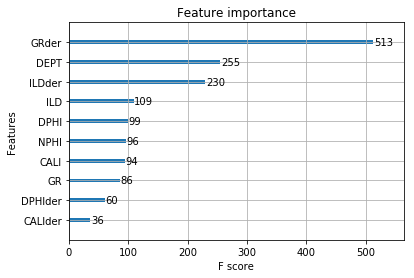

In [125]:
from xgboost import plot_importance
plot_importance(model2)

In [126]:
max(data_df_pred[data_df_pred['SitID']==111771]['Pick_pred'])

0.0036689937

In [127]:
idx = data_df_pred.groupby(['SitID'])['Pick_pred'].transform(max) == data_df_pred['Pick_pred']
df_pred1=data_df_pred[idx]

In [128]:
df_pred1.shape

(2390, 29)

In [129]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(df_pred1['DEPT'],df_pred1['Pick']))

157.47561076276824

In [148]:
from sklearn.model_selection import GridSearchCV
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import auc

/home/ubuntu/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [130]:
display= ['CALI','DEPT','DPHI','GR','NPHI', 'SitID']
df_display=train_X[display]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9169e87a20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f917c27f630>]], dtype=object)

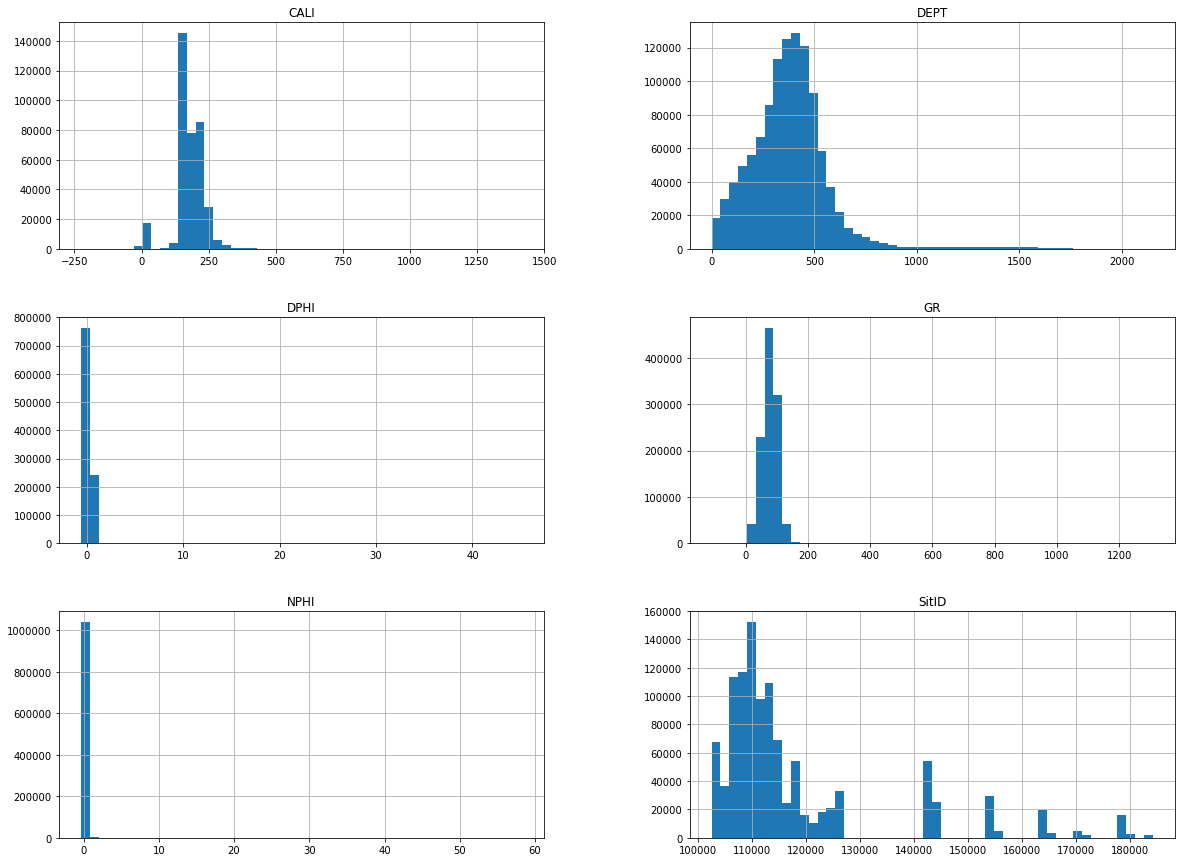

In [131]:
import matplotlib.pyplot as plt
% matplotlib inline
df_display.hist(bins=50, figsize=(20,15))

In [18]:
def derivative(well_df,rangeOfCurves):
   well_der = pd.DataFrame(well_df['DEPT'])
   for eachC in rangeOfCurves:
       # make a placeholder array for results
       log_der= []
       log_der = np.gradient(well_df[eachC])
       col_name= eachC+'der'
       well_der[col_name]=log_der
   return well_der

In [19]:
#features = ['CALI','DEPT','DPHI','GR','ILD','NPHI', 'SitID']
test_df=derivative(data_df,['GR'])
test1_df=derivative(data_df,['CALI'])
test2_df=derivative(data_df,['DPHI'])
test3_df=derivative(data_df,['NPHI'])
test4_df=derivative(data_df,['ILD'])

In [20]:
data_df['GRder']=test_df['GRder']
data_df['CALIder']=test1_df['CALIder']
data_df['DPHIder']=test2_df['DPHIder']
data_df['NPHIder']=test3_df['NPHIder']
data_df['ILDder']=test4_df['ILDder']

In [140]:
features2 = ['CALI','DEPT','DPHI','GR','ILD','NPHI', 'SitID','CALIder','DPHIder','GRder','ILDder']
label = 'new_pick2'
train_X2 = data_df[features2]
train_y = data_df[label]

In [141]:
from xgboost.sklearn import XGBRegressor
model2 = XGBRegressor()
model2.fit(train_X2, train_y)
result2= model2.predict(train_X2)
result2

array([ -1.41441822e-04,  -1.41441822e-04,  -1.41441822e-04, ...,
         4.46438789e-05,   1.50501728e-05,   4.96506691e-05], dtype=float32)

In [142]:
data_df_pred['Pick_pred2'] = result2

In [143]:
idx2 = data_df_pred.groupby(['SitID'])['Pick_pred2'].transform(max) == data_df_pred['Pick_pred2']
df_pred2=data_df_pred[idx2]

In [144]:
df_pred2.shape()

(1453, 30)

In [145]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(df_pred2['DEPT'],df_pred2['Pick']))

160.11968072969904

In [83]:
well_data=data_df.copy()

In [84]:
well_data.shape

(1494792, 41)

In [85]:
id_array = well_data['SitID'].unique()
id_array_permutation = np.random.permutation(id_array)
train_index = id_array_permutation[:int(len(id_array)*.8)]
test_index = id_array_permutation[int(len(id_array)*.8)+1:]
train_df = well_data.loc[well_data['SitID'].isin(train_index)]
test_df = well_data.loc[well_data['SitID'].isin(test_index)]

In [10]:
#features3 = ['DEPT', 'ILD', 'DPHI','GR', 'NPHI']
#label = 'Pick'

In [86]:
features = ['CALI','DEPT','DPHI','GR','ILD','NPHI']
label = 'new_pick2'

In [87]:
seed = 123

In [88]:
from sklearn.metrics import mean_squared_error

In [89]:
from xgboost.sklearn import XGBRegressor
#params_final = (
#    gamma=0, 
#    alpha=0.2, 
#    maxdepth=3, 
#    subsample=0.8, 
#    colsamplebytree= 0.8, 
#    n_estimators= 100, 
#    learningrate= 0.1, 
#    minchildweight= 1
#)
train_X = train_df[features]
train_y = train_df[label]
test_X = test_df[features]
test_y = test_df[label]

In [90]:
model = XGBRegressor(
    gamma=0, 
    reg_alpha=0.2, 
    max_depth=3, 
    subsample=0.8, 
    colsample_bytree= 0.8, 
    n_estimators= 300, 
    learning_rate= 0.03, 
    min_child_weight= 3)
model.fit(train_X,train_y)
result = model.predict(test_X)
result

array([  6.19292259e-05,   6.19292259e-05,   6.19292259e-05, ...,
         5.29766083e-04,   5.39302826e-04,   5.39302826e-04], dtype=float32)

In [91]:
test_df_pred = test_df.copy()
test_df_pred['Pick_pred'] = result
test_df_pred.head()

CALI  COND  DELT    DEPT   DPHI  DPHI:1  DPHI:2  DT       GR  GR:1  \
0   NaN   NaN   NaN  320.00  0.241     NaN     NaN NaN  104.886   NaN   
1   NaN   NaN   NaN  320.25  0.243     NaN     NaN NaN  106.053   NaN   
2   NaN   NaN   NaN  320.50  0.239     NaN     NaN NaN  105.512   NaN   
3   NaN   NaN   NaN  320.75  0.210     NaN     NaN NaN  103.872   NaN   
4   NaN   NaN   NaN  321.00  0.214     NaN     NaN NaN   99.974   NaN   

     ...                      UWI      UWI (AGS)  new_pick  new_pick2  \
0    ...      00/06-30-071-09W4/0  0714093006000    173.00          0   
1    ...      00/06-30-071-09W4/0  0714093006000    172.75          0   
2    ...      00/06-30-071-09W4/0  0714093006000    172.50          0   
3    ...      00/06-30-071-09W4/0  0714093006000    172.25          0   
4    ...      00/06-30-071-09W4/0  0714093006000    172.00          0   

     GRder  CALIder  DPHIder  NPHIder   ILDder  Pick_pred  
0  32.4105      NaN   0.0930   0.1595 -13.4035   0.000062  
1   0.3130      NaN  -0.0010   0.0045  -0.0770   0.000062  
2  -1.0905      NaN  -0.0165   0.0125  -0.0160   0.000062  
3  -2.7690      NaN  -0.0125   0.0105   0.0320   0.000018  
4  -2.8300      NaN   0.0070   0.0010   0.0465   0.000045  

[5 rows x 42 columns]

In [92]:
idx = test_df_pred.groupby(['SitID'])['Pick_pred'].transform(max) == test_df_pred['Pick_pred']
test_df_pred2=test_df_pred[idx]
        
        
# Score
final_score = np.sqrt(mean_squared_error(test_df_pred2['DEPT'],test_df_pred2['Pick']))
print("Prediction RMSE: {}".format(final_score))

Prediction RMSE: 136.921949194076


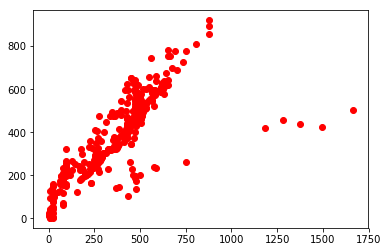

In [114]:
plt.plot(test_df_pred2['DEPT'],test_df_pred2['Pick'], 'ro')

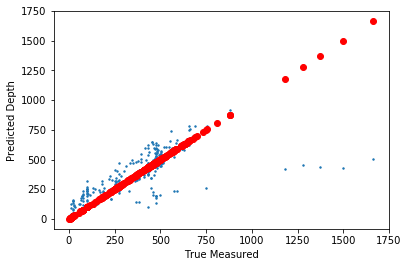

In [123]:
plt.scatter(test_df_pred2['DEPT'],test_df_pred2['Pick'], s=2)
plt.plot(test_df_pred2['DEPT'],test_df_pred2['DEPT'], 'ro')
#plt.plot([Y_all.min(), Y_all.max()], [Y_all.min(), Y_all.max()], 'k--', lw=2)
plt.xlabel('True Measured')
plt.ylabel('Predicted Depth')

In [94]:
display=['DEPT','Pick','SitID','UWI']
test_df_pred3=test_df_pred2[display]

In [96]:
test_df_pred3

DEPT    Pick   SitID                  UWI
736  504.000  493.00  106489  00/06-30-071-09W4/0
188  377.000  490.50  102592  00/07-25-067-05W4/0
742  460.500  456.00  111040  00/10-33-078-11W4/0
371  266.301  322.00  112371  00/11-29-080-16W4/0
744  556.000  556.00  109340  00/11-02-075-21W4/0
58   691.156  779.68  110028  00/06-36-076-25W4/0
307  753.406  779.68  110028  00/06-36-076-25W4/0
26    21.500  136.50  121444  AA/16-12-093-13W4/0
740  438.917  404.16  112356  00/10-20-080-14W4/0
467  256.958  312.72  110334  00/11-07-077-06W4/0
40    97.000  253.00  114847  00/04-20-084-15W4/0
849  623.730  598.63  108162  00/07-33-073-20W4/0
636  509.000  516.00  141876  00/06-22-069-06W4/0
518  229.500  164.00  184128  AA/10-29-094-07W4/0
519  229.750  164.00  184128  AA/10-29-094-07W4/0
315  458.366  230.43  115297  AA/06-24-085-08W4/0
353  200.901  200.50  113003  00/11-27-081-04W4/0
5      6.250   35.00  119918  AB/04-23-092-11W4/0
670  432.500  437.00  104779  00/07-31-069-13W4/0
661  265.250  253.00  143720  00/01-05-085-15W4/0
796  504.000  482.00  107972  00/06-13-073-06W4/0
399  577.264  237.13  120259  AA/10-29-092-17W4/0
335  193.547  262.74  113867  00/06-34-082-16W4/0
840  410.000  393.00  124894  AA/08-30-096-16W4/0
88    22.000    1.22  125235  AA/15-24-097-08W4/0
787  586.750  585.00  108186  00/09-10-073-25W4/0
776  504.000  475.00  107223  00/06-12-072-08W4/0
658  479.500  503.00  109941  00/11-10-076-14W4/0
840  430.000  413.00  111800  00/14-14-079-22W4/0
707  432.782  428.24  107333  00/11-15-072-16W4/0
..       ...     ...     ...                  ...
793  323.250  318.00  124885  00/14-09-096-15W4/0
794  323.500  318.00  124885  00/14-09-096-15W4/0
795  323.750  318.00  124885  00/14-09-096-15W4/0
305  459.688  499.87  111832  00/07-34-079-03W5/0
488  272.000  327.00  110387  00/15-26-077-09W4/0
163  383.694  145.08  144378  AA/04-34-091-07W4/0
682  500.500  548.00  153892  00/13-06-078-01W5/0
277  364.906  476.71  106569  00/11-04-071-18W4/0
18    69.494  195.99  112290  00/07-29-080-04W4/0
19    69.799  195.99  112290  00/07-29-080-04W4/0
226  559.420  744.32  109378  00/11-24-075-26W4/0
708  444.404  409.96  113822  00/07-11-082-07W4/0
290  285.860  360.88  111775  00/06-16-079-16W4/0
863  374.246  327.96  110981  00/01-28-078-02W4/0
320  430.000  470.00  153284  00/12-30-069-07W4/0
767  471.750  446.50  102633  00/08-05-067-12W4/0
856  614.000  609.00  106710  00/07-29-071-02W5/0
581  274.301  217.00  113013  AA/11-19-081-05W4/0
465  461.893  441.35  111807  00/06-02-079-23W4/0
358  169.500  177.00  143555  00/11-20-084-04W4/0
925  431.250  375.00  178238  00/15-23-075-04W4/0
788  456.080  448.06  111038  00/06-20-078-11W4/0
694  498.500  495.00  108055  00/06-34-073-08W4/0
779  464.750  446.00  164584  00/12-23-082-11W4/0
876  504.000  496.00  111131  00/11-26-078-01W5/0
82    20.500   16.50  125119  AA/10-32-097-07W4/0
614  284.682  282.55  113868  00/06-36-082-16W4/0
760  430.000  437.00  143229  00/04-12-081-23W4/0
273  473.917  188.98  120253  AA/10-26-092-16W4/0
88    97.000  321.00  124881  AA/11-27-096-14W4/0

[409 rows x 4 columns]

In [97]:
r = Well.from_las('./SPE_006_originalData/OilSandsDB/Logs/00-10-20-080-14W4-0.LAS')

In [98]:
r00

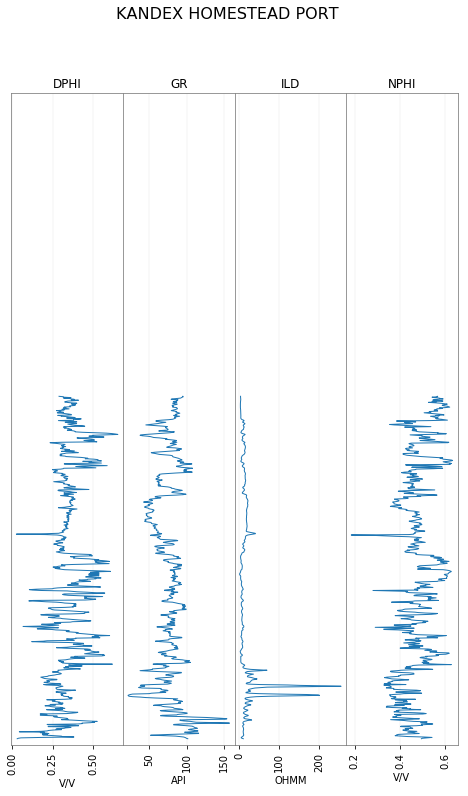

In [104]:
tracks = [ 'DPHI', 'GR', 'ILD', 'NPHI']
r.plot(tracks=tracks)

In [37]:
well_data=data_df.copy()

In [106]:
import lasio
l = lasio.read("./SPE_006_originalData/OilSandsDB/Logs/00-10-20-080-14W4-0.LAS")
l

In [110]:
l_df

DEPT       GR     CALI   DPHI      ILD                  UWI   SitID  \
0     30.48   85.425  170.590  0.215   63.483  AA/06-36-090-09W4/0  118153   
1     30.73   84.199  169.585  0.224   49.541  AA/06-36-090-09W4/0  118153   
2     30.98   87.275  167.554  0.230   53.442  AA/06-36-090-09W4/0  118153   
3     31.23   96.496  162.433  0.238   63.407  AA/06-36-090-09W4/0  118153   
4     31.48  112.478  157.290  0.247   63.384  AA/06-36-090-09W4/0  118153   
5     31.73  106.336  155.258  0.253   47.620  AA/06-36-090-09W4/0  118153   
6     31.98  105.725  154.254  0.256   35.101  AA/06-36-090-09W4/0  118153   
7     32.23  119.863  154.308  0.265   34.420  AA/06-36-090-09W4/0  118153   
8     32.48  127.241  154.341  0.269   38.568  AA/06-36-090-09W4/0  118153   
9     32.73  113.723  156.481  0.259   40.828  AA/06-36-090-09W4/0  118153   
10    32.98  111.268  157.572  0.259   45.752  AA/06-36-090-09W4/0  118153   
11    33.23  124.792  158.632  0.261   56.385  AA/06-36-090-09W4/0  118153   
12    33.48  121.108  159.734  0.270   59.683  AA/06-36-090-09W4/0  118153   
13    33.73  110.048  159.756  0.256   57.432  AA/06-36-090-09W4/0  118153   
14    33.98  109.437  162.922  0.252   44.823  AA/06-36-090-09W4/0  118153   
15    34.23  105.138  169.212  0.244   41.517  AA/06-36-090-09W4/0  118153   
16    34.48  102.683  171.308  0.225   39.197  AA/06-36-090-09W4/0  118153   
17    34.73  103.916  164.090  0.236   33.647  AA/06-36-090-09W4/0  118153   
18    34.98  112.523  163.096  0.259   30.578  AA/06-36-090-09W4/0  118153   
19    35.23  105.765  167.311  0.266   31.154  AA/06-36-090-09W4/0  118153   
20    35.48   93.477  172.541  0.254   33.604  AA/06-36-090-09W4/0  118153   
21    35.73  100.855  171.547  0.255   35.572  AA/06-36-090-09W4/0  118153   
22    35.98   95.942  169.505  0.245   43.013  AA/06-36-090-09W4/0  118153   
23    36.23  108.237  168.512  0.250   43.820  AA/06-36-090-09W4/0  118153   
24    36.48  115.614  168.566  0.255   42.978  AA/06-36-090-09W4/0  118153   
25    36.73  119.920  168.609  0.258   40.577  AA/06-36-090-09W4/0  118153   
26    36.98  127.297  161.392  0.252   37.591  AA/06-36-090-09W4/0  118153   
27    37.23  112.551  159.371  0.231   35.491  AA/06-36-090-09W4/0  118153   
28    37.48  104.565  162.527  0.218   39.017  AA/06-36-090-09W4/0  118153   
29    37.73  107.641  165.704  0.222   47.188  AA/06-36-090-09W4/0  118153   
..      ...      ...      ...    ...      ...                  ...     ...   
375  124.23   73.703  160.720  0.252   80.538  AA/06-36-090-09W4/0  118153   
376  124.48   74.935  160.796  0.259   91.986  AA/06-36-090-09W4/0  118153   
377  124.73   74.324  160.818  0.256   95.521  AA/06-36-090-09W4/0  118153   
378  124.98   71.869  160.850  0.255  105.004  AA/06-36-090-09W4/0  118153   
379  125.23   63.883  160.894  0.255  104.975  AA/06-36-090-09W4/0  118153   
380  125.48   63.885  163.034  0.255   80.382  AA/06-36-090-09W4/0  118153   
381  125.73   66.347  164.104  0.250   48.051  AA/06-36-090-09W4/0  118153   
382  125.98   67.579  165.185  0.234   54.886  AA/06-36-090-09W4/0  118153   
383  126.23   76.187  165.261  0.243   73.002  AA/06-36-090-09W4/0  118153   
384  126.48   71.887  165.293  0.260   89.969  AA/06-36-090-09W4/0  118153   
385  126.73   69.432  164.289  0.267   78.714  AA/06-36-090-09W4/0  118153   
386  126.98   66.362  164.332  0.269   78.685  AA/06-36-090-09W4/0  118153   
387  127.23   66.980  164.387  0.269   96.981  AA/06-36-090-09W4/0  118153   
388  127.48   68.213  164.430  0.262   91.563  AA/06-36-090-09W4/0  118153   
389  127.73   65.757  164.474  0.264   84.802  AA/06-36-090-09W4/0  118153   
390  127.98   67.605  164.517  0.270   95.047  AA/06-36-090-09W4/0  118153   
391  128.23   76.212  164.572  0.270   95.012  AA/06-36-090-09W4/0  118153   
392  128.48   74.371  164.615  0.265   80.013  AA/06-36-090-09W4/0  118153   
393  128.73   70.072  163.621  0.259   68.677  AA/06-36-090-09W4/0  118153   
394  128.98   72.534  160.542

In [36]:
features2 = ['CALI','DEPT','DPHI','GR','ILD','NPHI','CALIder','DPHIder','GRder','ILDder']
label = 'new_pick2'

In [48]:
from xgboost.sklearn import XGBRegressor
#params_final = (
#    gamma=0, 
#    alpha=0.2, 
#    maxdepth=3, 
#    subsample=0.8, 
#    colsamplebytree= 0.8, 
#    n_estimators= 100, 
#    learningrate= 0.1, 
#    minchildweight= 1
#)
train_X = train_df[features2]
train_y = train_df[label]
test_X = test_df[features2]
test_y = test_df[label]

In [49]:
model2 = XGBRegressor(
    gamma=0, 
    reg_alpha=0.2, 
    max_depth=3, 
    subsample=0.8, 
    colsample_bytree= 0.8, 
    n_estimators= 300, 
    learning_rate= 0.03, 
    min_child_weight= 3)
model2.fit(train_X,train_y)
result2 = model2.predict(test_X)
result2

array([ 0.00188521,  0.00092727,  0.00097615, ...,  0.00025219,
        0.00050485,  0.00075358], dtype=float32)

In [50]:
test_df_pred = test_df.copy()
test_df_pred['Pick_pred2'] = result2
test_df_pred.head()

CALI  COND  DELT     DEPT   DPHI  DPHI:1  DPHI:2  DT       GR  GR:1  \
0   NaN   NaN   NaN  106.680  0.239     NaN     NaN NaN  104.506   NaN   
1   NaN   NaN   NaN  106.985  0.217     NaN     NaN NaN  104.513   NaN   
2   NaN   NaN   NaN  107.290  0.246     NaN     NaN NaN  104.522   NaN   
3   NaN   NaN   NaN  107.594  0.266     NaN     NaN NaN  102.684   NaN   
4   NaN   NaN   NaN  107.899  0.276     NaN     NaN NaN   92.245   NaN   

      ...                      UWI      UWI (AGS)  new_pick  new_pick2  \
0     ...      00/11-11-081-03W4/0  0814031111000   117.960          0   
1     ...      00/11-11-081-03W4/0  0814031111000   117.655          0   
2     ...      00/11-11-081-03W4/0  0814031111000   117.350          0   
3     ...      00/11-11-081-03W4/0  0814031111000   117.046          0   
4     ...      00/11-11-081-03W4/0  0814031111000   116.741          0   

     GRder  CALIder  DPHIder  NPHIder  ILDder  Pick_pred2  
0  46.2715      NaN   0.0625   0.1475 -2.7845    0.001885  
1   0.0080      NaN   0.0035   0.0010  1.0450    0.000927  
2  -0.9145      NaN   0.0245  -0.0235  1.1490    0.000976  
3  -6.1385      NaN   0.0150  -0.0210  1.2380    0.001669  
4  -7.9820      NaN  -0.0010  -0.0060  0.8790    0.001450  

[5 rows x 42 columns]

In [51]:
idx = test_df_pred.groupby(['SitID'])['Pick_pred2'].transform(max) == test_df_pred['Pick_pred2']
test_df_pred2=test_df_pred[idx]
        
        
# Score
final_score = np.sqrt(mean_squared_error(test_df_pred2['DEPT'],test_df_pred2['Pick']))
print("Prediction RMSE: {}".format(final_score))

Prediction RMSE: 162.07304617844164
